# Time series prediction using LSTM

## Dataset
- Daily minimum temperatures in Melbourne, Australia, 1981-1990
- Units: Degrees Celcius

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Question 1

### Load the data
- load daily-minimum-temperatures-in-me.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
min_temp_df = pd.read_csv('/content/drive/MyDrive/Sequence Models in NLP Lab/daily-minimum-temperatures-in-me.csv')

### Print the data
- First 5 rows only

In [32]:
min_temp_df.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Set index column
- Set the DataFrame index using "Date" column

In [33]:
min_temp_df = min_temp_df.sort_values(by = 'Date')

In [34]:
min_temp_df.index = min_temp_df.Date
min_temp_df.drop(columns='Date', inplace = True)

In [35]:
min_temp_df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


## Question 2

### Check the total count of null values in the data

In [36]:
min_temp_df['Temperature'].isna().sum()

0

### Drop all the rows with null values
- use dropna() method

In [37]:
min_temp_df.dropna(axis=0, inplace=True)

## Question 3

### Describe your dataframe
- use describe() method

In [38]:
min_temp_df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


### Plot the dataframe
- use plot() method

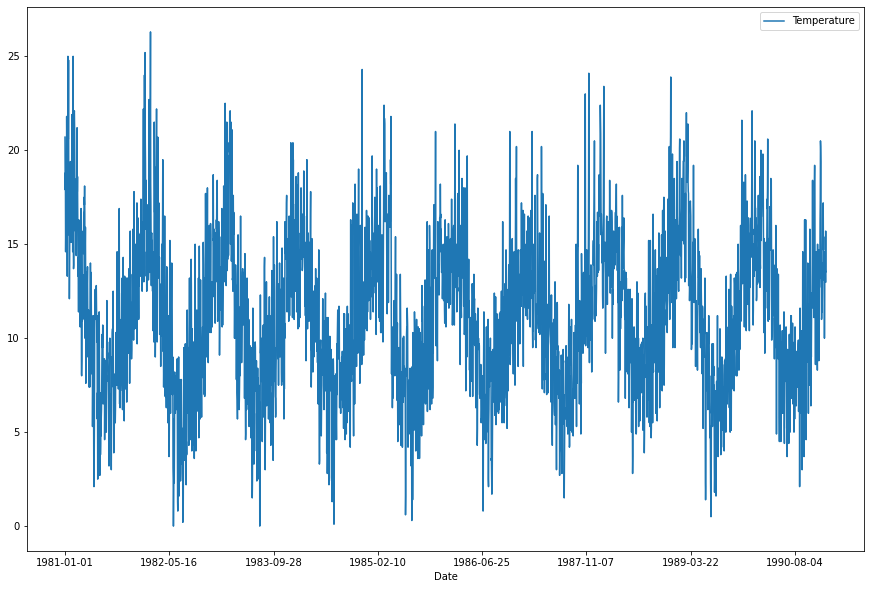

In [39]:
min_temp_df.plot(figsize = (15,10))

### Get representation of the distribution of data using histogram
- use hist() method

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9db6f5c4d0>]],
      dtype=object)

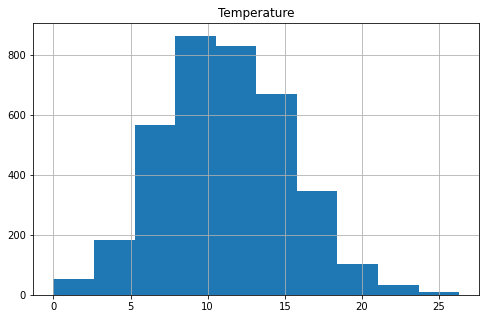

In [40]:
min_temp_df.hist(figsize=(8,5))

### Check minimum and maximum temperature
- use min() and max() methods

In [41]:
print('Minimum Temperature = ', round(min_temp_df.Temperature.min()))
print('Maximum Temperature = ', round(min_temp_df.Temperature.max()))

Minimum Temperature =  0
Maximum Temperature =  26


## Question 4

### Split the dataset into training and testing
- training data: 75%
- testing data: 25%

In [102]:
print('There are {} data points'.format(min_temp_df.shape[0]))
print('For training data we will use 75% of datapoints, i.e data till row number {}.'.format(round(min_temp_df.shape[0]*0.75,0)-1))

There are 3650 data points
For training data we will use 75% of datapoints, i.e data till row number 2737.0.


In [103]:
print(min_temp_df.iloc[2737,:])
print('So we will consider 1988-07-01 as the cutoff date')

Temperature    6.0
Name: 1988-07-01, dtype: float64
So we will consider 1988-07-01 as the cutoff date


In [104]:
train_df = min_temp_df[min_temp_df.index<'1988-07-01']
test_df = min_temp_df[min_temp_df.index >= '1988-07-01']

In [105]:
print('Training data rows: ', train_df.shape[0])
print('Test data rows: ', test_df.shape[0])

Training data rows:  2737
Test data rows:  913


### Normalize the data
- normalize temperature values using MinMaxScaler
- feature_range: 0-1
- fit MinMaxScaler on train data and transform it
  - use fit_transform() method
- transform test data using MinMaxScaler object
  - use transform() method

In [106]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train_df)
test_scaled = sc.transform(test_df)

### Print scaled train and test data
- print only first 5 values

In [107]:
train_scaled[0:5]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046]])

In [108]:
test_scaled[0:5]

array([[0.22813688],
       [0.22053232],
       [0.18631179],
       [0.19011407],
       [0.31939163]])

## Question 5

### Create sequential data
Map the temperature at a particular day 'd' to the temperature at day t
'd+n', where n is any number you define.

For example: to map temperatures of consecutive days, use d+1, i.e. lookback = 1
- Below function takes data as input and returns sequential data.
- X as features and y as labels

In [143]:
import numpy as np
def create_seq_data(data, lookback=1):
  X, y = list(), list()
  
  for day in range((len(data)-lookback)):
    X.append(data[day: day+lookback, 0])
    y.append(data[day+lookback, 0])
  return np.array(X), np.array(y)

### Use the above function to create train and test sets
- Get X_train and y_train
- Get X_test and y_test
- lookback = 1

In [144]:
#Assign values of batch size and lookback here
batch_size = 1
lookback= 1
X_train,y_train = create_seq_data(train_scaled, lookback)

In [145]:
X_test, y_test = create_seq_data(test_scaled, lookback)

### Reshape the data
- Reshape X_train and X_test
- use np.reshape() method
- this is to be done to make the data ready for input in model

In [146]:
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

### Print shape of data
- print shape of X_train and X_test

In [147]:
print('Shape of X_train = ',X_train.shape )
print('Shape of X_test = ',X_test.shape )

Shape of X_train =  (2736, 1, 1)
Shape of X_test =  (912, 1, 1)


## Question 6

### Define sequential model
- initialize a Sequential model
- add an LSTM layer
  - units: 10
  - stateful: True
  - pass a `batch_input_shape` argument to your layer
  - batch_input_shape: (batch_size, look_back, 1)
    - batch_size: 1
    - look_back: 1
- add Dense layer with 1 neuron

In [148]:
import tensorflow as tf
#Build Model
model = tf.keras.Sequential()

#Add LSTM layer
model.add(tf.keras.layers.LSTM(10,stateful = True, batch_input_shape=(batch_size, lookback, 1)))

#Add Dense layer
model.add(tf.keras.layers.Dense(1))

## Question 7

### compile your model
- loss: mean_squared_error
- optimizer: adam

In [149]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

### summarize your model
- use summary() method

In [150]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 10)                   480       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Question 8

### fit your model
- epochs: 50
- batch_size: 1

In [151]:
model.fit(X_train , y_train, batch_size=batch_size, epochs = 50, validation_data=(X_test, y_test))

Epoch 1/50
2736/2736 [==============================] - 6s 2ms/step - loss: 0.0478 - val_loss: 0.0092
Epoch 2/50
2736/2736 [==============================] - 4s 1ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 3/50
2736/2736 [==============================] - 4s 2ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 4/50
2736/2736 [==============================] - 5s 2ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 5/50
2736/2736 [==============================] - 4s 2ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 6/50
2736/2736 [==============================] - 4s 2ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 7/50
2736/2736 [==============================] - 4s 1ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 8/50
2736/2736 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0093
Epoch 9/50
2736/2736 [==============================] - 4s 2ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 10/50
2736/2736 [==============================] - 4s 2ms/step - loss: 0.009

## Question 9

### make predictions on train data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [182]:
train_pred = model.predict(X_train, batch_size=1)

### reset model state
- if you are using stateful=True in your model then you should call reset_states every time, when you want to make consecutive model calls independent.
- use reset_states() method

In [183]:
model.reset_states()

### make predictions on test data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [184]:
test_pred = model.predict(X_test, batch_size=1)

## Question 10

### Inverse train predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [185]:
train_pred = sc.inverse_transform(train_pred)

In [189]:
train_true = sc.inverse_transform([y_train]).T

### Inverse test predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [187]:
test_pred = sc.inverse_transform(test_pred)

In [194]:
test_true = sc.inverse_transform([y_test]).T

### Evaluate train predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print training RMSE

In [158]:
from sklearn.metrics import mean_squared_error
import math

In [190]:
train_RMSE = math.sqrt(mean_squared_error(train_true, train_pred))
print('Train RMSE = ', round(train_RMSE,2))

Train RMSE =  2.6


### Evaluate test predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print testing RMSE

In [195]:
test_RMSE = math.sqrt(mean_squared_error(test_true, test_pred))
print('Test RMSE = ', round(test_RMSE,2))

Test RMSE =  2.51
